In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

In [2]:
#Parameters
P = 1

# Generate data
M = 16
B = 10000

## Helper Functions

In [3]:
def one_hot(a, M):
    onehot = np.zeros(M)
    onehot[a] = 1
    return onehot

In [4]:
def get_norm_factor(x, P, P_M):
    return np.sum(P_M*np.abs(x)**2)

In [5]:
def awgn(x, sigma2):
    noise_t = np.sqrt(sigma2)*torch.randn(x.shape)
    return torch.add(x, noise_t)

In [6]:
def normalization(x, P):
    c = torch.mean(x**2)
    return torch.sqrt(P / c) * x

In [7]:
def get_norm_qam(M, P, P_M):
    r = np.arange(np.array(np.sqrt(M)))
    r = 2*(r-np.mean(r))
    r = np.meshgrid(r,r)
    const = np.expand_dims(np.reshape(r[0]+1j*r[1],[-1]),axis=0)
    norm_factor = np.sqrt(P/get_norm_factor(const, P, P_M))
    norm_constellation = norm_factor * const
    return norm_constellation

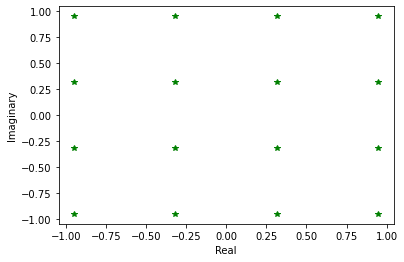

In [8]:
# Test the constellation retrieval
P_M = np.ones(M)*1/M
data = get_norm_qam(M, 1, P_M)
x = data.real
# extract imaginary part using numpy array
y = data.imag
  
# plot the complex numbers
plt.plot(x, y, 'g*')
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.show()

In [9]:
def sampler(P_M, B):
    samples = np.zeros((np.sum(np.rint(B*P_M).astype(int)),0))
    for idx, p in enumerate(P_M):
        occurrences = np.rint(B*p).astype(int)
        samples = np.append(samples, np.ones(occurrences)*idx)
    np.random.shuffle(samples)
    return samples.astype(int)

In [10]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

[4.21603092e-04 1.14603602e-03 3.11524890e-03 8.46812447e-03
 2.30187489e-02 6.25714468e-02 1.70086827e-01 4.62343930e-01
 1.70086827e-01 6.25714468e-02 2.30187489e-02 8.46812447e-03
 3.11524890e-03 1.14603602e-03 4.21603092e-04]
0.9999999999999998
[0.02721088 0.05442177 0.08163265 0.         0.10884354 0.13605442
 0.16326531 0.         0.19047619 0.16326531 0.13605442 0.
 0.10884354 0.08163265 0.05442177 0.02721088]


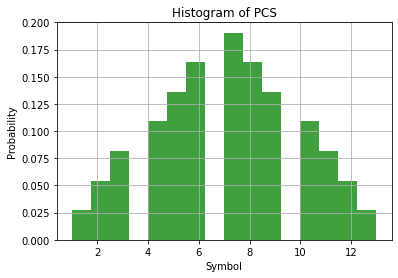

In [11]:
# Test the sampler mechanism
# mu, sigma = 0, 8
# norm = scipy.stats.norm(mu, sigma)
# P_M = [norm.pdf(i) for i in range(-9, 8)]
#print(P_M)
p = np.ones(M)*1/M
p1 = np.arange(0,7)
p2 = np.flip(np.arange(0,8))
p = np.append(p1,p2)
print(np.exp(p)/sum(np.exp(p))) #softmax
print(np.sum(np.exp(p)/sum(np.exp(p)))) #sum of softmax should add 1.0

x = sampler(p, 1000)

# the histogram of the data
n, bins, patches = plt.hist(x, M, density=True, facecolor='g', alpha=0.75)
print(n)

plt.xlabel('Symbol')
plt.ylabel('Probability')
plt.title('Histogram of PCS')
plt.grid(True)
plt.show()


## Definition of required NN

In [12]:
class Dist_Generator(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(M, M)
        self.lin1.weight = nn.Parameter(torch.full((M,M), 1/M)) # set weigths equal to uniform distribution
        
    def forward(self, y):
        return self.lin1(y)

In [13]:
class Mapper(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(M, 2)
        
    def forward(self, y):
        return self.lin1(y)

In [14]:
class Demapper(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(2, 2*M)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(2*M, 2*M)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(2*M, 2*M)
        self.act3 = nn.ReLU()
        self.lin4 = nn.Linear(2*M, 2*M)
        self.act4 = nn.ReLU()
        self.lin5 = nn.Linear(2*M, M)
        
    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        y = self.act3(self.lin3(y))
        return self.lin5(self.act4(self.lin4(y)))

## Loss Function
The Cross Equivocation must be corrected with an additional term to account for the changing statistics of the information source:
$$CE_{loss} + \sum \limits_{Y_{n}} P(Y_{n}|c_{i})log_{2}(Q_{\theta,P_{M},C_{M}}(c_{m}|Y_{n})$$
Regarding the prior term, the complex representation is reduced from (N,2) to N by means of multiplication. This is because we have a complex AWGN where the Noise is circularly symmetric.
This means:
$$P(Y_{R}Y_{I}|X_{R}X_{I}) = P(Y_{R}|X_{R})P(Y_{I}|_{R}X_{I})$$
While the posterior term is computed from the learned distribution and taking the max.

In [15]:
def calculate_py_given_x(z, sig2):
    return (1 / (np.sqrt(2 * np.pi * sig2))) * np.exp(-z ** 2 / sig2 / 2)

In [39]:
# CE loss function and correct with additional term
def custom_loss_fn(ce, logit, ind, zhat, sig2):
    #print(logit.shape)
    term_1 = ce(logit, ind)
    #print('term 1: ', term_1)
    q = np.amax(nn.functional.softmax(logit, 1).detach().numpy(), 1)# Q(c_i|Y_n) <-- learned
    p = np.multiply.reduce(calculate_py_given_x(zhat, sig2), 1)# P(Y_n|c_i), as we have complex circularly symmetric, distributions are indep. Reduction is multiplication, therefore.
    #print('q.shape: ', q.shape)
    #print('p.shape: ', p.shape)
    term_2 = np.mean(p*np.log2(q))
    return term_1 + term_2

In [17]:
def complex2real(cplx):
    real = torch.flatten(cplx.real)
    imag = torch.flatten(cplx.imag)
    result = torch.transpose(torch.stack((real, imag)), 0, 1)
    return result

In [18]:
def plot_2D_PDF(const, pmf):
    s = pmf*100+100
    plt.scatter(const.real, const.imag, s, c="g")
    plt.show()

## Training Loop

---SNR = 0 dB---
epoch 0: Loss = 3.5101 dB
epoch 500: Loss = 3.0630 dB
epoch 1000: Loss = 3.0608 dB
epoch 1500: Loss = 3.0672 dB
epoch 2000: Loss = 3.0560 dB
epoch 2500: Loss = 3.0583 dB
epoch 3000: Loss = 3.0544 dB
epoch 3500: Loss = 3.0466 dB
epoch 4000: Loss = 3.0635 dB


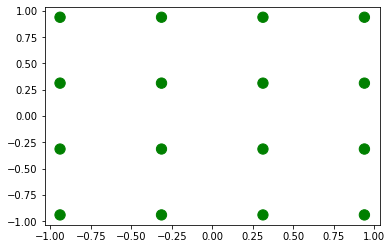

---SNR = 2 dB---
epoch 0: Loss = 2.6866 dB
epoch 500: Loss = 2.7151 dB
epoch 1000: Loss = 2.7290 dB
epoch 1500: Loss = 2.7138 dB
epoch 2000: Loss = 2.6942 dB
epoch 2500: Loss = 2.6987 dB
epoch 3000: Loss = 2.6955 dB
epoch 3500: Loss = 2.7062 dB
epoch 4000: Loss = 2.7162 dB


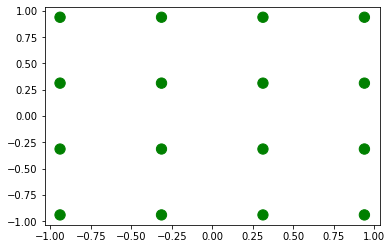

---SNR = 4 dB---
epoch 0: Loss = 2.2549 dB
epoch 500: Loss = 2.2662 dB
epoch 1000: Loss = 2.3014 dB
epoch 1500: Loss = 2.2972 dB
epoch 2000: Loss = 2.3184 dB
epoch 2500: Loss = 2.2841 dB
epoch 3000: Loss = 2.2881 dB
epoch 3500: Loss = 2.2891 dB
epoch 4000: Loss = 2.2795 dB


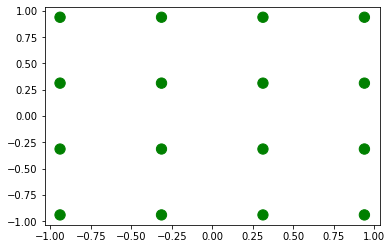

---SNR = 6 dB---
epoch 0: Loss = 1.7446 dB
epoch 500: Loss = 1.8280 dB
epoch 1000: Loss = 1.8017 dB
epoch 1500: Loss = 1.8263 dB
epoch 2000: Loss = 1.7852 dB
epoch 2500: Loss = 1.8451 dB
epoch 3000: Loss = 1.8246 dB
epoch 3500: Loss = 1.8306 dB
epoch 4000: Loss = 1.8147 dB


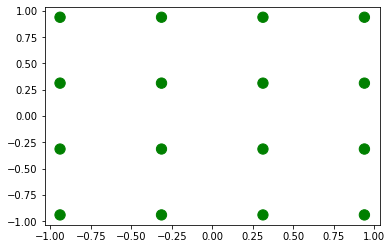

---SNR = 8 dB---
epoch 0: Loss = 1.2144 dB
epoch 500: Loss = 1.2902 dB
epoch 1000: Loss = 1.3069 dB
epoch 1500: Loss = 1.2632 dB
epoch 2000: Loss = 1.3269 dB
epoch 2500: Loss = 1.2993 dB
epoch 3000: Loss = 1.3309 dB
epoch 3500: Loss = 1.3270 dB
epoch 4000: Loss = 1.3153 dB


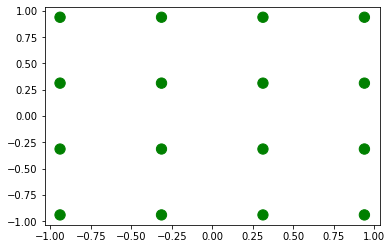

---SNR = 10 dB---
epoch 0: Loss = 0.6560 dB
epoch 500: Loss = 0.8278 dB
epoch 1000: Loss = 0.8498 dB
epoch 1500: Loss = 0.8461 dB
epoch 2000: Loss = 0.8732 dB
epoch 2500: Loss = 0.8247 dB
epoch 3000: Loss = 0.8415 dB
epoch 3500: Loss = 0.8564 dB
epoch 4000: Loss = 0.8490 dB


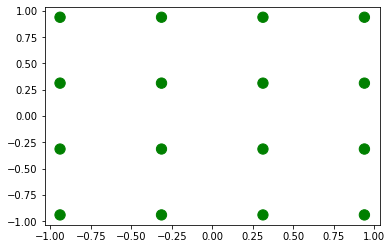

In [40]:
P = 1 # normalization parameter
SNRdBs = np.array([0, 2, 4, 6, 8, 10]) 
SNRs = 10**(SNRdBs/10)

# Initialize network
dist_generator = Dist_Generator(M)
mapper = Mapper(M)
demap = Demapper(M)
loss_fn = nn.CrossEntropyLoss()
pcs_only = True

for (k,snr) in enumerate(SNRs):
    sigma2 = P/snr
    print(f'---SNR = {SNRdBs[k]} dB---')

    # Optimizer
    if pcs_only:
        optimizer = optim.Adam(list(demap.parameters()) + list(dist_generator.parameters()), lr=0.01)
    else:
        optimizer = optim.Adam(list(mapper.parameters()) + list(demap.parameters()) + list(dist_generator.parameters()), lr=0.01)
    
    # Training loop
    for j in range(4001):
        # first generate the distribution
        l_M = dist_generator(torch.ones(M)).reshape(-1, M)
        P_M = nn.functional.softmax(l_M, 1).detach().numpy()[0]

        # Sample indexes
        indices = sampler(P_M, B)
        # get onehot from sampled indices
        onehot = np.array([one_hot(i, M) for i in indices])
        # convert array to tensors
        onehot_t = torch.tensor(onehot).float()
        indices_t = torch.tensor(indices)
        indices_t = indices_t.type(torch.LongTensor)#labels

        # Get normalized constellation
        constellation = complex2real(torch.tensor(get_norm_qam(M, P, P_M)))

        if(pcs_only):
            #xhat = torch.matmul(onehot_t, torch.transpose(constellation, 0, 1)) # equivalent to GCS with QAM fixed shape
            xhat = torch.matmul(onehot_t, constellation.float()).float()
        else:
            xhat = mapper(onehot_t)
        yhat = normalization(awgn(xhat, sigma2), P)

        l = demap(yhat)
        if pcs_only:
            zhat = (yhat-xhat).detach().numpy()
            loss = custom_loss_fn(loss_fn, l, indices_t, zhat, sigma2)
        else:
            loss = loss_fn(l, indices_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Printout and visualization
        if j % 500 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy()/np.log(2) :.4f} dB')
        if loss < 1e-3:
            break
    # Data for the plots
    if pcs_only:
        L_M = dist_generator(torch.ones(M)).reshape(-1, M)
        PCS = nn.functional.softmax(L_M, 1).detach().numpy()
        constellation = get_norm_qam(M, 1, PCS)
        plot_2D_PDF(constellation, PCS)
    else:
        a_plot = np.arange(M)
        onehot_plot = np.array([one_hot(a_plot[i], M) for i in range(M)])
        #learned_x = map(torch.tensor(onehot_plot).float()).detach().numpy()
        learned_x = mapper(torch.tensor(onehot_plot).float())
        learned_x = normalization(learned_x, P).detach().numpy()
        plt.scatter(learned_x[:,0], learned_x[:,1])
        plt.title(f'Learned Constellation for SNR = {SNRdBs[k]} dB')
        plt.grid()
        plt.show()